### Clean and Load Input Data and Labels
This section takes in the input data from the csv files, cleans the data,
 and loads them into a more manageable dataframe.



In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset


drive.mount('/content/drive')

inputDataDf = pd.read_csv('/content/test_measure.csv')
subjectInfoDf = pd.read_csv('/content/subject-info.csv')

labelsDf = pd.read_csv('/content/annotated_vt_results.csv')


# Filter the labels to only include ones that have less than 800 difference and are not blank
labelsDf = labelsDf[(labelsDf['difference'] <= 800) & (~labelsDf['difference'].isna())]
labelsDf = labelsDf[['ID_test', 'Average']]

# Filter and Clean the input data
inputDataDf = inputDataDf[inputDataDf['ID_test'].isin(labelsDf['ID_test'])]
inputDataDf = inputDataDf.dropna(subset=['HR'])
timeIncludedDf = inputDataDf.groupby('ID_test')['time'].apply(list).reset_index()
heartRateDf = inputDataDf.groupby('ID_test')['HR'].apply(list).reset_index()

inputDataDf = pd.merge(timeIncludedDf, heartRateDf, on='ID_test', how='inner')

# Sort the input data
inputDataDf[['part1', 'part2']] = inputDataDf['ID_test'].str.split('_', expand=True)
inputDataDf['part1'] = inputDataDf['part1'].astype(int)
inputDataDf['part2'] = inputDataDf['part2'].astype(int)
inputDataDf = inputDataDf.sort_values(by=['part1', 'part2'])
inputDataDf = inputDataDf.drop(columns=['part1', 'part2'])

subjectInfoDf = subjectInfoDf[subjectInfoDf['ID_test'].isin(labelsDf['ID_test'])]
subjectInfoDf = subjectInfoDf[['ID_test', 'Age', 'Weight', 'Height', 'Sex']]

paired_df = pd.merge(inputDataDf, subjectInfoDf, on='ID_test', how='inner')
paired_df = pd.merge(paired_df, labelsDf, on='ID_test', how='inner')
# print(inputDataDf)
# print(labelsDf)
print(paired_df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: "['ID_test'] not in index"

### Data Set

In [ ]:
class VTDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.hr_seqs = []
        self.static_feats = []
        self.targets = []

        for idx, row in df.iterrows():
            hr_array = np.array(row['HR'], dtype=np.float32)  # Heart rate sequence
            hr_array = hr_array.reshape(-1, 1)  # (sequence_length, 1)

            static = np.array([row['Age'], row['Weight'], row['Height'], row['Sex']], dtype=np.float32)

            self.hr_seqs.append(hr_array)
            self.static_feats.append(static)
            self.targets.append(row['Average'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        hr_seq = torch.tensor(self.hr_seqs[idx], dtype=torch.float32)
        static_feat = torch.tensor(self.static_feats[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)

        return hr_seq, static_feat, target



### Model Definition

In [ ]:
class VTLSTMPrediction(nn.Module):
    def __init__(self, static_input_size, hr_input_size=1, lstm_hidden_size=64, lstm_num_layers=1):
        super(VTLSTMPrediction, self).__init__()

        # LSTM for heart rate time series
        self.lstm = nn.LSTM(input_size=hr_input_size, hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers, batch_first=True)

        # FC layer after LSTM
        self.fc1 = nn.Linear(lstm_hidden_size + static_input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, hr_seq, static_features):
        # hr_seq shape: (batch, sequence_len, 1)
        # static_features shape: (batch, 4)

        lstm_out, _ = self.lstm(hr_seq)  # lstm_out shape: (batch, sequence_len, hidden_size)
        lstm_last_output = lstm_out[:, -1, :]  # Take the last output (many strategies possible)

        combined = torch.cat((lstm_last_output, static_features), dim=1)  # (batch, hidden_size + 4)

        x = torch.relu(self.fc1(combined))
        output = self.fc2(x).squeeze(1)  # (batch,)
        return output



### Model Training

In [ ]:
dataset = VTDataset(paired_df)


# First, split indices for train/val/test
indices = list(range(len(dataset)))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)  # 70% train, 30% temp
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)    # 15% val, 15% test

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    hr_seqs, static_feats, targets = zip(*batch)  # unzip list of tuples

    # Pad heart rate sequences
    hr_seqs_padded = pad_sequence(hr_seqs, batch_first=True, padding_value=0.0)  # (batch, max_seq_len, 1)

    static_feats = torch.stack(static_feats)
    targets = torch.stack(targets)

    return hr_seqs_padded, static_feats, targets

batch_size = 16
train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VTLSTMPrediction(static_input_size=4).to(device)

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.MSELoss()


num_epochs = 20

train_loss_list = []
eval_loss_list = []
# --- Training and Validation ---
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    eval_loss = 0.0

    # Training
    with tqdm(train_loader, unit="batch") as training_epoch:
        training_epoch.set_description(f"Training Epoch {epoch+1}/{num_epochs}")
        for hr_seq_batch, static_feat_batch, y_batch in training_epoch:
            hr_seq_batch = hr_seq_batch.to(device)
            static_feat_batch = static_feat_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(hr_seq_batch, static_feat_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    running_loss /= len(train_loader)
    scheduler.step()

    # Validation
    model.eval()
    with tqdm(val_loader, unit="batch") as eval_epoch:
        eval_epoch.set_description(f"Validation Epoch {epoch+1}/{num_epochs}")
        for hr_seq_batch, static_feat_batch, y_batch in eval_epoch:
            hr_seq_batch = hr_seq_batch.to(device)
            static_feat_batch = static_feat_batch.to(device)
            y_batch = y_batch.to(device)

            with torch.no_grad():
                outputs = model(hr_seq_batch, static_feat_batch)
                loss = criterion(outputs, y_batch)
                eval_loss += loss.item()

    eval_loss /= len(val_loader)

    # Logging
    print(f'\tTrain Loss: {running_loss:.4f}')
    print(f'\tEval Loss : {eval_loss:.4f}')
    train_loss_list.append(running_loss)
    eval_loss_list.append(eval_loss)

Validation Epoch 1/20: 100%|██████████| 9/9 [00:00<00:00, 325.29batch/s]


	Train Loss: 3993141.7303
	Eval Loss : 4259096.9444


Validation Epoch 2/20: 100%|██████████| 9/9 [00:00<00:00, 418.39batch/s]


	Train Loss: 3792914.2303
	Eval Loss : 3997006.1667


Validation Epoch 3/20: 100%|██████████| 9/9 [00:00<00:00, 396.63batch/s]


	Train Loss: 3472784.8947
	Eval Loss : 3575597.0278


Validation Epoch 4/20: 100%|██████████| 9/9 [00:00<00:00, 425.12batch/s]


	Train Loss: 2992336.8158
	Eval Loss : 3005251.9722


Validation Epoch 5/20: 100%|██████████| 9/9 [00:00<00:00, 402.07batch/s]


	Train Loss: 2416864.5263
	Eval Loss : 2366151.3333


Validation Epoch 6/20: 100%|██████████| 9/9 [00:00<00:00, 448.50batch/s]


	Train Loss: 1833329.3207
	Eval Loss : 1768915.4722


Validation Epoch 7/20: 100%|██████████| 9/9 [00:00<00:00, 391.20batch/s]


	Train Loss: 1324169.6891
	Eval Loss : 1282714.4097


Validation Epoch 8/20: 100%|██████████| 9/9 [00:00<00:00, 436.98batch/s]


	Train Loss: 940573.1077
	Eval Loss : 932173.7986


Validation Epoch 9/20: 100%|██████████| 9/9 [00:00<00:00, 437.41batch/s]


	Train Loss: 699911.6780
	Eval Loss : 728010.0000


Validation Epoch 10/20: 100%|██████████| 9/9 [00:00<00:00, 308.58batch/s]


	Train Loss: 575982.7570
	Eval Loss : 623220.1910


Validation Epoch 11/20: 100%|██████████| 9/9 [00:00<00:00, 481.30batch/s]


	Train Loss: 530549.6447
	Eval Loss : 594969.4097


Validation Epoch 12/20: 100%|██████████| 9/9 [00:00<00:00, 443.86batch/s]


	Train Loss: 514392.0609
	Eval Loss : 577234.3403


Validation Epoch 13/20: 100%|██████████| 9/9 [00:00<00:00, 435.59batch/s]


	Train Loss: 503280.6003
	Eval Loss : 566540.6701


Validation Epoch 14/20: 100%|██████████| 9/9 [00:00<00:00, 493.91batch/s]


	Train Loss: 499756.0345
	Eval Loss : 557598.8542


Validation Epoch 15/20: 100%|██████████| 9/9 [00:00<00:00, 550.70batch/s]


	Train Loss: 496512.6579
	Eval Loss : 552083.3264


Validation Epoch 16/20: 100%|██████████| 9/9 [00:00<00:00, 557.72batch/s]


	Train Loss: 495261.0559
	Eval Loss : 549705.7396


Validation Epoch 17/20: 100%|██████████| 9/9 [00:00<00:00, 406.25batch/s]


	Train Loss: 494220.8035
	Eval Loss : 548065.1806


Validation Epoch 18/20: 100%|██████████| 9/9 [00:00<00:00, 559.36batch/s]


	Train Loss: 494780.4827
	Eval Loss : 545378.1597


Validation Epoch 19/20: 100%|██████████| 9/9 [00:00<00:00, 550.67batch/s]


	Train Loss: 493942.0419
	Eval Loss : 545334.4306


Validation Epoch 20/20: 100%|██████████| 9/9 [00:00<00:00, 567.51batch/s]

	Train Loss: 493041.8232
	Eval Loss : 543449.8924


### Plot Training and Validation Error

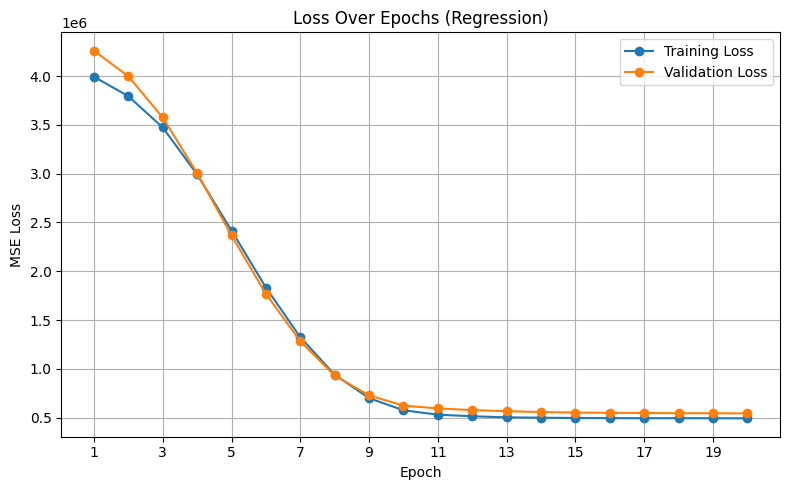

In [ ]:
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(8, 5))

# Plot Loss
plt.plot(epochs, train_loss_list, 'o-', label='Training Loss')
plt.plot(epochs, eval_loss_list, 'o-', label='Validation Loss')
plt.title('Loss Over Epochs (Regression)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.xticks(range(1, len(train_loss_list) + 1, 2))
plt.grid(True)

plt.tight_layout()
plt.show()

### Model Testing

In [ ]:
model.eval()
test_loss = 0.0
with tqdm(test_loader, unit="batch") as test_epoch:
    test_epoch.set_description(f"Testing")
    for hr_seq_batch, static_feat_batch, y_batch in test_epoch:
        hr_seq_batch = hr_seq_batch.to(device)
        static_feat_batch = static_feat_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            outputs = model(hr_seq_batch, static_feat_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Final Test Loss: {test_loss:.4f}")

Testing: 100%|██████████| 9/9 [00:00<00:00, 372.59batch/s]

Final Test Loss: 506363.9132


In [ ]:
model.eval()
all_targets = []
all_predictions = []

with torch.no_grad():
    for hr_seq_batch, static_feat_batch, y_batch in test_loader:
        hr_seq_batch = hr_seq_batch.to(device)
        static_feat_batch = static_feat_batch.to(device)

        outputs = model(hr_seq_batch, static_feat_batch)

        all_targets.extend(y_batch.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

# Convert to numpy arrays
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

# Compute metrics (e.g., MSE, MAE, R²)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(all_targets, all_predictions)
mae = mean_absolute_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.2f}")

Test MSE: 511573.84
Test MAE: 609.02
Test R²: 0.01


In [ ]:
# Get a test subject from the TEST SET (not original df)
test_subjects = paired_df.iloc[test_idx]  # Only use test_idx subjects!
test_subject = test_subjects.sample(42).iloc[0]  # Random test subject

print("\n--- Test Subject Info ---")
print(test_subject)

# Prepare HR sequence CORRECTLY
hr_array = torch.tensor(test_subject['HR'], dtype=torch.float32)  # Shape: (seq_len,)
hr_array = hr_array.unsqueeze(-1)  # Add feature dim -> (seq_len, 1)
hr_array = hr_array.unsqueeze(0)   # Add batch dim -> (1, seq_len, 1)
hr_array = hr_array.to(device)

# Prepare static features CORRECTLY
static_features = torch.tensor([
    test_subject['Age'],
    test_subject['Weight'],
    test_subject['Height'],
    test_subject['Sex']
], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 4)

# Verify shapes
print(f"\nHR array shape: {hr_array.shape}")  # Should be (1, seq_len, 1)
print(f"Static features shape: {static_features.shape}")  # Should be (1, 4)

# Predict
model.eval()
with torch.no_grad():
    pred_vt = model(hr_array, static_features)

print(f"\nPredicted VT: {pred_vt.item():.2f}")
print(f"Actual VT: {test_subject['Average']:.2f}")

NameError: name 'paired_df' is not defined